This notebook will describe experiments related to DUD-E

In [18]:
import pickle
from sklearn.metrics import roc_auc_score
import numpy as np
import seaborn as sns
import torch
import seaborn as sns
import pandas as pd
from pathlib import Path
from sklearn.metrics import f1_score, recall_score
import matplotlib.pyplot as plt


plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=17)
plt.rc('figure', titlesize=20)


In [19]:
def compute_enrichment_factor(scores, labels, n_percent):
    # this variant implements the equation from Xiaohua's paper
    
    sample_n = int(np.ceil(n_percent * labels.shape[0]))
    
    sorted_scores = sorted(zip(scores, labels), key=lambda x: x[0], reverse=True)

    top_n_sorted_scores = sorted_scores[:sample_n]

    # counting number of true positives in top x% of sorted compounds
    actives_sampled = sum([y for x, y in top_n_sorted_scores])
    # labels are binary, sum to count number of actives
    actives_database = sum(labels)

    norm_factor = (sample_n/len(labels))

    return (actives_sampled / actives_database) * (labels.shape[0]/sample_n)


In [20]:
data_p = Path("/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results")

In [21]:
list(data_p.glob("dude.random*.pkl"))[0].name

'dude.random.dyr.ecfp.atomwise.0.pkl'

In [22]:
dude_target_names = list(set([x.name.split('.')[2] for x in list(data_p.glob("dude.random*.pkl"))]))
dude_target_names

['random',
 'mk14',
 'try1',
 'parp1',
 'openhd-smiles-pe',
 'openhd-rp',
 'ada',
 'cdk2',
 'egfr',
 'pgh2',
 'kith',
 'pde5a',
 'pgh1',
 'aldr',
 'inha',
 'pygm',
 'dyr',
 'openhd-ecfp',
 'bace1',
 'ampc',
 'hivrt',
 'comt',
 'sahh',
 'aces',
 'fa10',
 'andr',
 'hs90a',
 'hmdh',
 'pparg',
 'openhd-selfies',
 'pur2',
 'rxra',
 'ace',
 'pnph',
 'src',
 'hivpr',
 'nram',
 'prgr',
 'mcr',
 'esr1',
 'thrb',
 'vgfr2',
 'gcr']

In [23]:
def load_pkl(pkl_path, model, return_sizes=False):
    
    with open(pkl_path, "rb") as handle:
        data = pickle.load(handle) # lets just use one seed
        
        
        if 0 in data.keys():
            data = data[0]

        
        if "encode_time" not in data.keys():
            return
    
    if isinstance(data["y_true"], np.ndarray):
        y_true = data["y_true"]
    else:
        y_true = np.concatenate(data["y_true"]) 
    y_pred = np.array(data["y_pred"])

    
    eta = np.array(data["eta"])

    if np.unique(y_true).shape[0] < 2 :
        metric = 0
    else:
        metric = recall_score(y_pred=y_pred, y_true=y_true)
        if model in ["rf", "mlp"]:
            eta= eta[:, 1]

    if return_sizes:
        return y_true, y_pred, eta, metric, data["encode_time"], data["train_time"], data["test_time"], data["train_size"], data["test_size"]
    else:
        return y_true, y_pred, eta, metric, data["encode_time"], data["train_time"], data["test_time"]


# DUD-E results

In [24]:
green_color_pal = sns.color_palette("Greens", 10)
blue_color_pal = sns.color_palette("Blues", 10)
rocket_color_pal = sns.color_palette("rocket", 10)

In [25]:
green_color_pal

[(0.9176931949250289, 0.9684275278738947, 0.901361014994233),
 (0.8459054209919262, 0.9399307958477509, 0.8228219915417148),
 (0.7558477508650518, 0.9033910034602076, 0.7290426758938869),
 (0.6436447520184544, 0.8561476355247981, 0.6197923875432525),
 (0.5185697808535179, 0.7983391003460207, 0.5150941945405614),
 (0.3827450980392157, 0.7332564398308343, 0.42737408688965783),
 (0.2452133794694348, 0.6602537485582468, 0.35695501730103807),
 (0.1566320645905421, 0.5657670126874279, 0.28608996539792386),
 (0.06082276047673972, 0.47958477508650516, 0.21599384851980008),
 (0.0, 0.38268358323721646, 0.15398692810457515)]

In [26]:
blue_color_pal

[(0.8978854286812764, 0.939038831218762, 0.977362552864283),
 (0.828881199538639, 0.8937639369473279, 0.954725105728566),
 (0.7506343713956171, 0.8478431372549019, 0.9282122260668974),
 (0.6325259515570935, 0.7976470588235294, 0.8868742791234141),
 (0.491764705882353, 0.7219684736639754, 0.8547789311803152),
 (0.36159938485198, 0.6427374086889658, 0.8165782391387928),
 (0.24816608996539793, 0.5618915801614763, 0.7709803921568628),
 (0.15072664359861593, 0.4644521337946943, 0.7207843137254902),
 (0.07481737793156479, 0.3732564398308343, 0.6552095347943099),
 (0.03137254901960784, 0.28161476355247983, 0.5582622068435218)]

In [27]:
rocket_color_pal

[(0.13501631, 0.07585609, 0.19044109),
 (0.26930915, 0.1091727, 0.2772502),
 (0.41282936, 0.12164769, 0.33467689),
 (0.57077365, 0.11135597, 0.35827146),
 (0.72398193, 0.08688725, 0.33943958),
 (0.85281737, 0.15657772, 0.27909826),
 (0.93078135, 0.31373977, 0.24468803),
 (0.95626788, 0.49187351, 0.33985601),
 (0.96388426, 0.64484214, 0.4861196),
 (0.96810471, 0.78634563, 0.66773889)]

In [49]:
   
#     "smiles-pe.ngram.1"
#     "smiles-pe.ngram.2"
#     "smiles-pe.ngram.3"
#     "selfies.selfies-charwise"
#     "Vina"

color_dict = {
    "smiles-pe.atomwise.0": rocket_color_pal[3],
    "smiles-pe.bpe.0": rocket_color_pal[3], 
    "selfies.None": green_color_pal[4],
    "ecfp": green_color_pal[6],
    "openhd-ecfp": green_color_pal[6],
    "rp": green_color_pal[8],
    "rf": blue_color_pal[4],
    "mlp": blue_color_pal[4],
}

marker_dict = {
    "smiles-pe.atomwise.0": "+",
    "smiles-pe.bpe.0": "+",
    "selfies.None": "*",
    "ecfp": "+",
    "openhd-ecfp": "+",
    "rp": "+",
    "rf": "^",
    "mlp": "+",
}


# model_order_list = [
#     ("smiles-pe.atomwise.0", "MoleHD-Atomw."),
#     ("smiles-pe.bpe.0", "MoleHD-BPE"),
#     ("selfies.None", "HDBind-SELFIES"),
#     ("ecfp", "HDBind-ECFP"),
#     ("openhd-ecfp", "OPENHD-ECFP"),
#     ("rp", "HDBind-ECFP+RP"),
#     ("rf", "RF"),
#     ("mlp", "MLP"),
#     ("Vina", "Vina")
# ]


# model_name_dict = {
#     "smiles-pe.atomwise.0": "MoleHD-Atomw.", 
#     "smiles-pe.bpe.0": "MoleHD-BPE",
#     "selfies.None": "HDBind-SELFIES",
#     "ecfp": "HDBind-ECFP",
#     "openhd-ecfp": "OPENHD-ECFP"
#     "rp": "HDBind-ECFP-RP",
#     "rf": "RF",
#     "mlp": "MLP",
#     "Vina": "Vina"
# }


# linestyle_dict = {
#     "smiles-pe.atomwise.0": "-", 
#     "smiles-pe.bpe.0": ":",
#     "selfies.None": "-",
#     "ecfp": ":",
#     "openhd-ecfp": "-"
#     "rp": "-.",
#     "rf": "-",
#     "mlp": ":",
#     "Vina": "-"
# }

In [52]:
def aggregate_dude_results(dataset, split):
    
    model_metric_dict = {}
    
    
#     enrich_1_f, enrich_1_ax = plt.subplots(1,1, figsize=(13,6))
#     enrich_10_f, enrich_10_ax = plt.subplots(1,1, figsize=(13,6))

#     enrich_f, enrich_ax = plt.subplots(1,2, figsize=(15,6), sharex=True, sharey=True)
    enrich_f, enrich_ax = plt.subplots(2,1, figsize=(12,10), sharex=True, sharey=False)
    enrich_ax = enrich_ax.flatten()
    enrich_1_ax, enrich_10_ax = enrich_ax[0], enrich_ax[1]
#     enrich_10_f, enrich_10_ax = plt.subplots(1,1, figsize=(13,6))


    
#     enrich_1_f.suptitle("Enrichment at 1\% of database")
#     enrich_10_f.suptitle("Enrichment at 10\% of database")
    
    f, ax = plt.subplots(1,3, figsize=(16,6))
    ax = ax.flatten()

    for model, color in color_dict.items():
        
        marker = marker_dict[model]
#         color, marker = model_tup
        
        model_metric_dict[model] = []
        
        metric_list = []
        encode_time_list = []
        train_time_list = []
        test_time_list = []
        eta_list = []
        data_path_list = list(data_p.glob(f"{dataset}.{split}.*.{model}*pkl"))
        
        train_size_list = []
        test_size_list = []
        target_size_list = []
        
        
        enrich_1_list = []
        enrich_10_list = []
        
        for path in data_path_list:
            
            
            print(path)
#             continue
#             import pdb 
#             pdb.set_trace()
            target = path.name.split(".")[2]
            split = path.name.split(".")[1]
            
            
            
            split_file = f"/usr/WS2/atom/gbsa_modeling/dude_smiles/{target}_gbsa_smiles_with_base_rdkit_smiles_train_valid_test_{split}_{split}.csv"
            split_df = pd.read_csv(split_file)
            
            train_size = split_df[split_df["subset"] == "train"].shape[0] 
            test_size = split_df[split_df["subset"] == "test"].shape[0]
            
            y_true, y_pred, eta, m, encode_time, train_time, test_time = load_pkl(path, model=model, return_sizes=False)
            

            if m is None:
                pass
            else:
                metric_list.append(m)
                encode_time_list.append(encode_time)
                train_time_list.append(train_time/10) # because i retrained 10 times
                test_time_list.append(test_time)
                eta_list.append(eta)
                train_size_list.append(train_size)
                test_size_list.append(test_size)
                
                
                
                enrich_1 = compute_enrichment_factor(scores=eta, labels=y_true, n_percent=.01)
                enrich_1_list.append(enrich_1)
                
                enrich_10 = compute_enrichment_factor(scores=eta, labels=y_true, n_percent=.1)
                enrich_10_list.append(enrich_10)

                target_size_list.append(train_size+test_size)
                
                model_metric_dict[model].append((m, enrich_1, enrich_10, train_size, test_size, train_time, test_time))
                
        sorted_metric_list = [x for _, x in sorted(zip(target_size_list, metric_list), key=lambda pair: pair[0])]
        sorted_encode_time_list = [x for _, x in sorted(zip(target_size_list, encode_time_list), key=lambda pair: pair[0])]
        sorted_train_time_list = [x for _, x in sorted(zip(target_size_list, train_time_list), key=lambda pair: pair[0])]
        sorted_test_time_list = [x for _, x in sorted(zip(target_size_list, test_time_list), key=lambda pair: pair[0])]
        sorted_enrich_1_list = [x for _, x in sorted(zip(target_size_list, enrich_1_list), key=lambda pair: pair[0])]
        sorted_enrich_10_list = [x for _, x in sorted(zip(target_size_list, enrich_10_list), key=lambda pair: pair[0])]
        sorted_train_size_list = sorted(train_size_list)
        
        
        if model not in ["rf", "mlp"]:
            sns.scatterplot(x=[x for x in range(len(target_size_list))], y=sorted_encode_time_list, ax=ax[1], color=color, marker=marker, label=model)
        sns.scatterplot(x=[x for x in range(len(target_size_list))], y=sorted_train_time_list, ax=ax[2], color=color, marker=marker, label=model)

    ax[0].set_ylabel("roc-auc-score")
    ax[0].set_xlabel("DUD-E target")

    plt.legend()
    

    return f, ax, enrich_f, enrich_1_ax, enrich_10_ax, model_metric_dict




/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/dude.random.dyr.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/dude.random.inha.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/dude.random.aces.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/dude.random.cdk2.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/dude.random.kith.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/dude.random.esr1.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/dude.random.gcr.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/dude.random.rxra.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/dude.random.ampc.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/dude.random.hivrt.smiles-pe.atomwi

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/dude.random.bace1.selfies.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/dude.random.nram.selfies.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/dude.random.pygm.selfies.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/dude.random.mcr.selfies.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/dude.random.pgh2.selfies.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/dude.random.parp1.selfies.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/dude.random.ada.selfies.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/dude.random.comt.selfies.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/dude.random.pparg.selfies.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/dude.random.vgfr2.selfies.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hd

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/dude.random.hs90a.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/dude.random.ace.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/dude.random.pde5a.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/dude.random.src.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/dude.random.hivpr.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/dude.random.aldr.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/dude.random.try1.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/dude.random.andr.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/dude.random.fa10.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/dude.random.sahh.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/

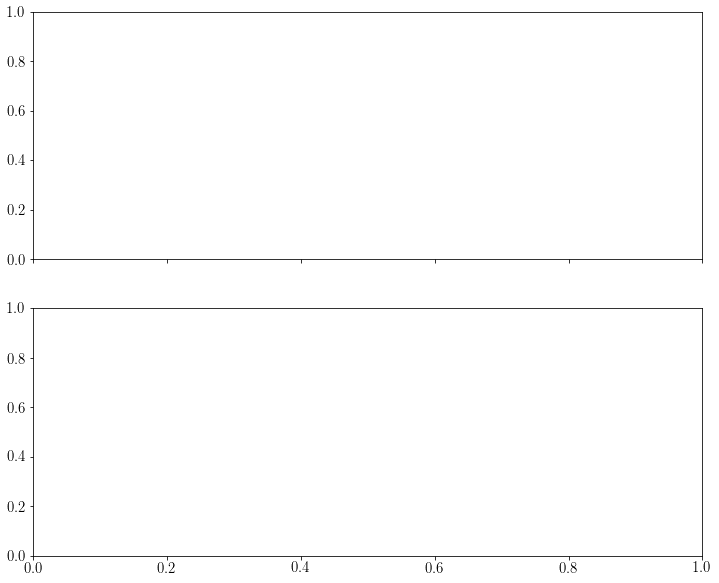

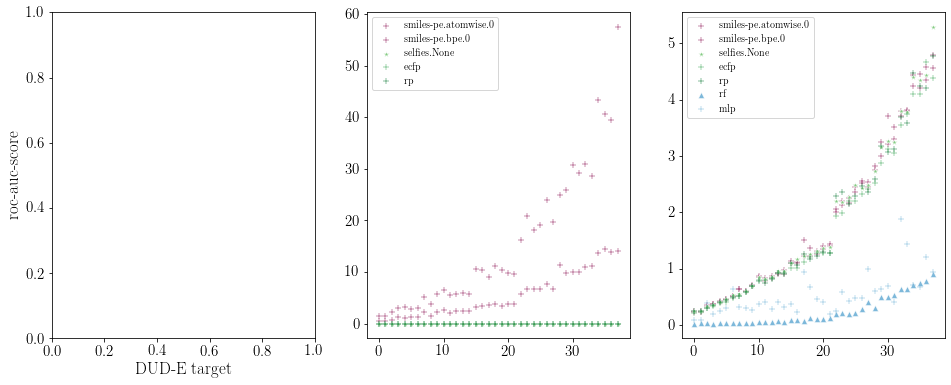

In [53]:
dude_f, dude_ax, dude_enrich_f, dude_enrich_1_ax, dude_enrich_10_ax, model_metric_dict = aggregate_dude_results(dataset="dude", split="random")


In [54]:
model_metric_dict.keys()

dict_keys(['smiles-pe.atomwise.0', 'smiles-pe.bpe.0', 'selfies.None', 'ecfp', 'openhd-ecfp', 'rp', 'rf', 'mlp'])

In [55]:
model_metric_dict

{'smiles-pe.atomwise.0': [(0.5185185185185185,
   array([52.03703704]),
   array([9.59548201]),
   11049,
   1382,
   20.635817050933838,
   1.8391976356506348),
  (0.5,
   array([26.]),
   array([8.66666667]),
   1627,
   204,
   3.4766929149627686,
   0.04956245422363281),
  (0.3888888888888889,
   array([50.54671717]),
   array([8.59886783]),
   16792,
   2099,
   32.400315046310425,
   0.4865560531616211),
  (0.37142857142857144,
   array([61.62417582]),
   array([8.28246499]),
   19826,
   2479,
   37.958051681518555,
   0.5052764415740967),
  (0.5,
   array([44.66666667]),
   array([9.92592593]),
   2121,
   266,
   4.328226327896118,
   0.09271049499511719),
  (0.20512820512820512,
   array([40.51282051]),
   array([9.48717949]),
   12521,
   1566,
   23.580803632736206,
   0.37378787994384766),
  (0.45454545454545453,
   array([38.40909091]),
   array([9.03743316]),
   6632,
   830,
   12.62043023109436,
   0.19605159759521484),
  (0.2222222222222222,
   array([62.55555556]),
 

In [56]:
[len(x) for x in model_metric_dict.values()]

[38, 38, 38, 38, 0, 38, 38, 38]

In [57]:
model_metric_df = pd.DataFrame(model_metric_dict)
model_metric_df_list = [pd.DataFrame({"metric": [tup[0] for tup in model_metric_df[col].values], 
                                      "enrich-1": [tup[1] for tup in model_metric_df[col].values],
                                      "enrich-10": [tup[2] for tup in model_metric_df[col].values],
                                      "model": [col]*len(model_metric_df),
                                       "train_size": [tup[3] for tup in model_metric_df[col].values],
                                     "test_size": [tup[4] for tup in model_metric_df[col].values],
                                     "train_time": [tup[5] for tup in model_metric_df[col].values],
                                     "test_time": [tup[6] for tup in model_metric_df[col].values]})
                                     for col in model_metric_df.columns]


model_metric_df = pd.concat(model_metric_df_list)

model_metric_df["latency"] = model_metric_df["test_time"] / model_metric_df["test_size"]

# model_metric_df["order-id"] = model_metric_df["model"].apply(lambda x: model_order_dict[x])

model_metric_df


ValueError: All arrays must be of the same length

In [ ]:
model_metric_df['enrich-1'] = model_metric_df['enrich-1'].apply(lambda x: float(np.array(x)))
model_metric_df['enrich-10'] = model_metric_df['enrich-10'].apply(lambda x: float(np.array(x)))

In [ ]:
sns.boxplot(data=model_metric_df, x="model", y="metric", 
            ax=dude_ax[0], palette=color_dict, order=[x[0] for x in model_order_list if x[0] is not "Vina"])
dude_f

## Vina Docking baseline

In [ ]:
vina_root_p = Path("/p/lustre1/jones289/DUDE-38/")


color_dict.update({"Vina": "salmon"})



vina_path_list = [path for path in vina_root_p.glob("*-active-summary.txt")]


df_list = []


# root_dude_dir = Path("/g/g13/jones289/workspace/hd-cuda-master/datasets/dude/dude_smiles/")
root_dude_dir = Path("/usr/workspace/atom/gbsa_modeling/dude_smiles/")
for idx, path in  enumerate(vina_path_list):
#     print(idx, path)
    target = path.name.split(".")[0].split("-")[0]
    print(target, idx+1, path)
    
    # for some reason don't have inactive data for abl1
    if target in ["abl1"]:
        continue
    if target in dude_target_names:
    
        active_df = pd.read_csv(f"/p/lustre1/jones289/DUDE-38/{target}-active-summary.txt", header=None, delim_whitespace=True)
        active_df['y_true'] = [1] * len(active_df)
    
        decoy_df = pd.read_csv(f"/p/lustre1/jones289/DUDE-38/{target}-decoy-summary.txt", header=None, delim_whitespace=True)
        decoy_df['y_true'] = [0] * len(decoy_df)
    
    
        target_df = pd.concat([active_df, decoy_df])
        
        target_df["target"] = [target] * len(target_df)
    
        target_df["vina"] = target_df[2]
        target_df["gbsa"] = target_df[3]
        
        target_df["cmpd_id"] = target_df[1]
        
        target_df["target_size"] = target_df.shape[0]
        
#         import pdb
#         pdb.set_trace()
        random_split_df = pd.read_csv(root_dude_dir/ Path(f"{target}_gbsa_smiles_with_base_rdkit_smiles_train_valid_test_random_random.csv"))
        
        
#         import pdb
#         pdb.set_trace()

        # we only use the scores from the test set to attempt an even comparison
    
        merged_df = pd.merge(target_df, random_split_df, on="cmpd_id")
        merged_df = merged_df.loc[merged_df['subset'] == "test"]

        print(merged_df.shape)
    
        df_list.append(merged_df)
    else:
        pass

df = pd.concat(df_list)
    

In [ ]:
set(df['target'].values.tolist())

In [ ]:
df

In [ ]:
target_size_list = []
vina_enrich_1_list = []
vina_enrich_10_list = []

for target, target_df in df.groupby("target"):
    
    ef_1 = compute_enrichment_factor(scores=np.abs(target_df["vina"]), labels=target_df["y_true"], n_percent=0.01)
    ef_10 = compute_enrichment_factor(scores=np.abs(target_df["vina"]), labels=target_df["y_true"], n_percent=0.1)

    
    target_size_list.append(target_df.shape[0])
    
    vina_enrich_1_list.append(ef_1)
    vina_enrich_10_list.append(ef_10)
    
    
    print(f"{target}, {ef_1:.4f}\t{ef_10:.4f}\t{target_df.shape[0]}")
    
sorted_vina_enrich_1_list = [x for _, x in sorted(zip(target_size_list, vina_enrich_1_list), key=lambda pair: pair[0])]
sorted_vina_enrich_10_list = [x for _, x in sorted(zip(target_size_list, vina_enrich_10_list), key=lambda pair: pair[0])]



I think it would be good to move away from the per-target (sorted by size) scatter plot and instead make a series of box plots...this should make it easier to compare the enrichment factors as you increase the amount of data that you are allowed to screen

In [ ]:
model_metric_df = pd.concat([model_metric_df, pd.DataFrame({"metric": [0]*38, "enrich-1": sorted_vina_enrich_1_list, 
                                            "enrich-10": sorted_vina_enrich_10_list,
                                          "model": ["Vina"]*38, 
                                                           })])


model_metric_df

In [ ]:
sns.boxplot(data=model_metric_df, x="model", y="enrich-1", ax=dude_enrich_1_ax, palette=color_dict,
           order=[x[0] for x in model_order_list])
dude_enrich_1_ax.set_title("(a) DUD-E Enrichment at 1\%", fontdict={"fontsize": 18})
dude_enrich_1_ax.tick_params(axis="x", labelrotation=22.5)
# dude_enrich_1_ax.set_ylabel("Enrch. at 1\%", rotation_mode="anchor")
dude_enrich_1_ax.set_xlabel("")
dude_enrich_1_ax.set_ylabel("")

labels = [x[1] for x in model_order_list]

dude_enrich_1_ax.set_xticklabels(labels)
# plt.tight_layout()
# dude_enrich_1_f.savefig("dude_enrich_1.png", dpi=600, bbox_inches="tight")
# dude_enrich_1_f

In [ ]:
sns.boxplot(data=model_metric_df, x="model", y="enrich-10", ax=dude_enrich_10_ax, palette=color_dict)
dude_enrich_10_ax.set_title("(b) DUD-E Enrichment at 10\%", fontdict={"fontsize": 18})

dude_enrich_10_ax.tick_params(axis="x", labelrotation=22.5)
# dude_enrich_10_ax.set_ylabel("Enrch. at 10\%", rotation_mode="anchor")
dude_enrich_10_ax.set_xlabel("")
dude_enrich_10_ax.set_ylabel("")

labels = [x[1] for x in model_order_list]

dude_enrich_10_ax.set_xticklabels(labels)
# plt.tight_layout()
dude_enrich_f.savefig("dude_enrich.png", dpi=600, bbox_inches="tight")
# dude_enrich_10_f

In [ ]:
dude_enrich_f

In [ ]:
model_metric_df.groupby('model').describe()[['enrich-1', 'enrich-10']]

In [ ]:
model_metric_df.groupby('model').describe()['latency']['mean']['ecfp'] + 
model_metric_df.groupby('model').describe()['latency']['mean']['rp'] +
model_metric_df.groupby('model').describe()['latency']['mean']['ecfp']

In [ ]:
# HD-CUDA is deprecated version of OpenHD, which is a GPU-accelerated version of HD

#def hd_cuda_main(f, ax):
#     root_dir = Path("/g/g13/jones289/workspace/hd-cuda-master/datasets/dude/deepchem_feats")
    
#     train_size_list = []
#     encode_time_list = []
#     train_time_list = []
#     test_time_list = []

# #     import pdb
# #     pdb.set_trace()
#     for path in root_dir.glob("*/ecfp/run.out"):
# #         print(path)
# #         '''
#         df = pd.read_csv(path, header=None)
# #         print(df.head(df.shape[0]))
# #         '''
#         num_train_epochs = int(df.loc[4][0])
        
#         encode_time = float(df.loc[21][0].split(' ')[-1]) /1000
#         train_time = float(df.loc[22][0].split(' ')[-1]) / 1000 / num_train_epochs
#         test_time = float(df.loc[23][0].split(' ')[-1]) /1000
#         train_size = int(df.loc[13][0])
        
#         encode_time_list.append(encode_time)
#         train_time_list.append(train_time)
#         test_time_list.append(test_time)
#         train_size_list.append(train_size)
    
#     sorted_encode_time_list = [x for _, x in sorted(zip(train_size_list, encode_time_list), key=lambda pair: pair[0])]
#     sorted_train_time_list = [x for _, x in sorted(zip(train_size_list, train_time_list), key=lambda pair: pair[0])]
#     sorted_test_time_list = [x for _, x in sorted(zip(train_size_list, test_time_list), key=lambda pair: pair[0])]
#     sorted_train_size_list = sorted(train_size_list)
# #         '''
        
#     sns.scatterplot(x=[x for x in range(len(sorted_train_size_list))], y=sorted_encode_time_list, ax=ax[1], label="HD-CUDA", color="lightcoral")
#     ax[1].set_ylabel("encode-time (s)")
#     sns.scatterplot(x=[x for x in range(len(sorted_train_size_list))], y=sorted_train_time_list, ax=ax[2], label="HD-CUDA", color="lightcoral")
#     ax[2].set_ylabel("train-time-per-epoch (s)")
# #     sns.scatterplot(x=sorted_train_size_list, y=sorted_test_time_list, ax=ax[2], label="HD-CUDA")
# #     ax[2].set_ylabel("test-time (s)")
#     return f, ax

        
# hd_cuda_main(f=dude_f, ax=dude_ax)
# dude_ax[1].set_yscale("log")
# dude_f

